In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

In [42]:
tf.__version__

'2.9.2'

In [43]:
data_dir = '/content/drive/MyDrive/Skripsi/dataset2'
os.listdir(data_dir)

['mengkal', 'matang', 'mentah']

In [44]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/Skripsi/dataset2')

Found 579 files belonging to 3 classes.


In [143]:
print('Total anggur Matang :', len(os.listdir('/content/drive/MyDrive/Skripsi/dataset2/matang')))
print('Total anggur Mengkal :', len(os.listdir('/content/drive/MyDrive/Skripsi/dataset2/mengkal')))
print('Total anggur Mentah :', len(os.listdir('/content/drive/MyDrive/Skripsi/dataset2/mentah')))

Total anggur Matang : 193
Total anggur Mengkal : 193
Total anggur Mentah : 193


In [45]:
data_iterator = data.as_numpy_iterator()

In [46]:
# Get another batch from the iterator
batch = data_iterator.next()

In [47]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [48]:
# 0 = matang || 1 = mengkal || 2 = mentah

batch[1]

array([0, 1, 1, 1, 0, 2, 0, 2, 1, 0, 1, 2, 1, 0, 0, 1, 1, 1, 2, 1, 2, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 2, 1], dtype=int32)

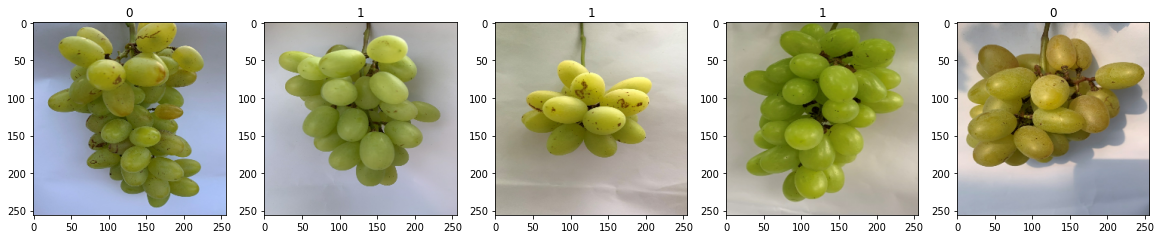

In [49]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Preprocess Data

In [50]:
# Scale
data = data.map(lambda x, y: (x/255, y))

In [51]:
# Split
len(data)
train_size = int(len(data)*.8)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [52]:
len(data)

19

In [53]:
test_size

1

In [54]:
train_size+val_size+test_size

19

In [55]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Build the deep neural network

In [56]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152V2
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(256, 256, 3))),
    #tf.keras.layers.Dropout(0.4),  
    # Flatten the results to feed into a CNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  
])
model.layers[0].trainable = False

In [63]:
# versi DeepLizard
model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [64]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_3 (Dense)             (None, 512)               67109376  
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 125,573,123
Trainable params: 67,241,475
Non-trainable params: 58,331,648
_________________________________________________________________


In [65]:
# versi Nick
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, validation_data=val, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
15/15 [==============================] - 22s 830ms/step - loss: 11.1560 - accuracy: 0.6958 - val_loss: 0.9435 - val_accuracy: 0.8854
Epoch 2/20
15/15 [==============================] - 11s 665ms/step - loss: 1.0316 - accuracy: 0.8292 - val_loss: 0.8684 - val_accuracy: 0.8333
Epoch 3/20
15/15 [==============================] - 9s 542ms/step - loss: 0.6483 - accuracy: 0.8021 - val_loss: 0.3383 - val_accuracy: 0.8542
Epoch 4/20
15/15 [==============================] - 10s 633ms/step - loss: 0.3497 - accuracy: 0.8313 - val_loss: 0.4236 - val_accuracy: 0.8854
Epoch 5/20
15/15 [==============================] - 9s 526ms/step - loss: 0.3689 - accuracy: 0.8750 - val_loss: 0.2676 - val_accuracy: 0.8646
Epoch 6/20
15/15 [==============================] - 9s 533ms/step - loss: 0.3579 - accuracy: 0.8625 - val_loss: 0.3265 - val_accuracy: 0.8854
Epoch 7/20
15/15 [==============================] - 10s 610ms/step - loss: 0.5303 - accuracy: 0.8771 - val_loss: 0.3703 - val_accuracy: 0.8750
E

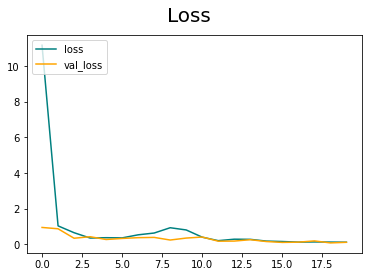

In [66]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

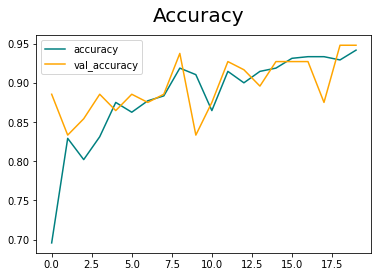

In [67]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Evaluate performance

In [68]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [69]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [70]:
len(test)

1

In [71]:
model.evaluate(test)

1/1 [==============================] - 3s 3s/step - loss: 0.0013 - accuracy: 1.0000


[0.0013081756187602878, 1.0]

Testing data baru

In [72]:
import cv2

Class 0

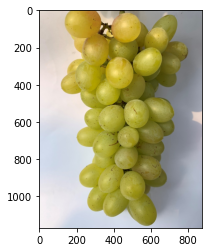

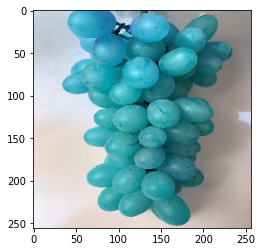

1/1 [==============================] - 0s 45ms/step


array([[9.9979717e-01, 7.4558161e-15, 2.0285444e-04]], dtype=float32)

In [97]:
img = cv2.imread('/content/drive/MyDrive/Skripsi/tes2/matang/matang20.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

Class 1

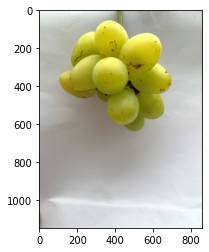

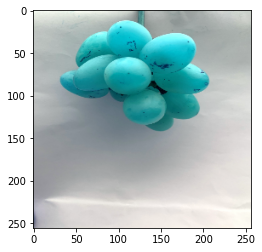

1/1 [==============================] - 0s 38ms/step


array([[1.1181115e-07, 9.9999988e-01, 1.8359304e-15]], dtype=float32)

In [121]:
img = cv2.imread('/content/drive/MyDrive/Skripsi/tes2/mengkal/mengkal20.jpg')

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

Class 2

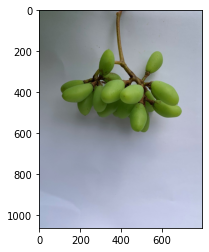

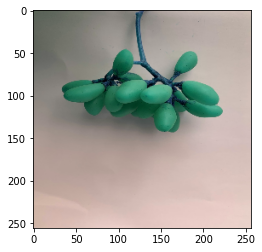

1/1 [==============================] - 0s 64ms/step


array([[7.2804975e-37, 0.0000000e+00, 1.0000000e+00]], dtype=float32)

In [142]:
img = cv2.imread('/content/drive/MyDrive/Skripsi/tes2/mentah/mentah20.jpg')

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize/255, 0))
yhat